In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def MSE(x, y):
    return np.sum((x - y)**2) / len(x)

def lin_act(x):
    return x

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def grad_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

class Layer:   
    def __init__(self, neurons, input_shape, weights, bias, activation):
        self.neurons = neurons
        self.input_shape = input_shape
        
        assert weights.shape == (input_shape[1], neurons)
        self.weights = weights
        
        assert bias.shape == (1, neurons)
        self.bias = bias
        
        self.activation = activation
        self.last_a = None
    
    
    def make_factory(neurons, input_shape, activation, factory):
        return Layer(
            neurons = neurons,
            input_shape = input_shape,
            weights = factory((input_shape[1], neurons)),
            bias = factory((1, neurons)),
            activation = activation
        )
    
    def make_zero(neurons, input_shape, activation):
        return Layer.make_factory(neurons, input_shape, activation, np.zeros)
    
    def make_random(neurons, input_shape, activation):
        random_balanced = lambda shape: np.random.random(shape) -0.5
        return Layer.make_factory(neurons, input_shape, activation, random_balanced)
    
    def apply(self, inputs):
        intensities = inputs @ self.weights
        self.last_a = intensities + self.bias
        return self.activation(intensities + self.bias)
    
    def apply_no_intensities(self, inputs):
        intensities = inputs @ self.weights
        return self.activation(intensities + self.bias)
    
    def __str__(self):
        return f"LAYER(\nW:\n {repr(self.weights)} \nb:\n{repr(self.bias)})\n"
    
    def __repr__(self):
        return str(self)


class NN:
    def __init__(self, *layers, input_shape):
        self.input_shape = input_shape
        self.layers = [*layers]
        self.errors = None
        self.last_inputs = None
        
    def get_last_shape(self):
        if self.layers:
            return self.layers[-1].weights.shape
        else:
            return self.input_shape
    
    def add_new_zero_layer(self, neurons, activation=sigmoid):
        layer = Layer.make_zero(
            neurons,
            self.get_last_shape(),
            activation
        )
        self.layers.append(layer)
        return layer
    
    def add_new_random_layer(self, neurons, activation=sigmoid):
        layer = Layer.make_random(
            neurons,
            self.get_last_shape(),
            activation
        )
        self.layers.append(layer)
        return layer
        
    def apply(self, inputs):
        self.last_inputs = inputs
        x = inputs
        for layer in self.layers:
            x = layer.apply(x)
        return x
    
    def backpropagate(self, yhat, y):
        errors = [None] * len(self.layers)
        errors[-1] = (yhat - y)
        for i in range(len(errors)-2, -1, -1):
            uhm = errors[i+1] @ np.transpose(self.layers[i+1].weights)
            errors[i] = grad_sigmoid(self.layers[i].last_a) * uhm
        grad = [None] * len(self.layers)
        grad_b = [None] * len(self.layers)
        
        for k in range(len(errors)):
            if k == 0:
                f_a = self.layers[0].activation(self.last_inputs)
            else:
                cur_layer = self.layers[k-1]
                f_a = cur_layer.activation(cur_layer.last_a)
            
            grad[k] = np.transpose(f_a) @ errors[k]
            grad_b[k] = errors[k] 
        return grad, grad_b
    
    def gradient_descent(self, x, y, rate=1e-3):
        yhat = self.apply(x[0])
        sumg, sumgb = self.backpropagate(yhat, y[0])
        for i in range(len(sumg)):
            sumg[i] *= - rate
            sumgb[i] *= - rate
            
        for i, x_i in enumerate(x[1:]):
            yhat = self.apply(x_i)
            g, gb = self.backpropagate(yhat, y[i])
            for i in range(len(self.layers)):
                sumg[i] += -rate*g[i]
                sumgb[i] += -rate*gb[i]
        
        for i in range(len(self.layers)):
            self.layers[i].weights += sumg[i]
            self.layers[i].bias += sumgb[i]
            
    def stochastic_descent(self, x, y, rate=1e-3):
        index = np.random.randint(x.shape[0])
        x_i = x[index]
        y_i = y[index]
        yhat_i = self.apply(x_i)
        g, gb = self.backpropagate(yhat_i, y_i)
        for i in range(len(self.layers)):
            self.layers[i].weights -= rate*g[i]
            self.layers[i].bias -= rate*gb[i]
    
class Trainer:
    def __init__(self, nn):
        self.nn = nn
        
    def backpropagate(self, x, y):
        yhat = nn.apply(x)
        

In [84]:
nn = NN(input_shape=(0,1))
nn.add_new_random_layer(10)
nn.add_new_random_layer(10)
nn.add_new_random_layer(1, activation=lin_act)

LAYER(
W:
 array([[ 0.06530718],
       [-0.4778819 ],
       [ 0.0984033 ],
       [ 0.31514399],
       [-0.21670936],
       [-0.34101495],
       [ 0.48876277],
       [ 0.19316011],
       [ 0.25705946],
       [ 0.37668375]]) 
b:
array([[-0.08732965]]))

In [85]:
df = pd.read_csv("LAB1_DANE/regression/square-simple-training.csv")
x = np.array(df.iloc[:,1]).reshape((100, 1))
min_x = np.min(x)
max_x = np.max(x)
# x = (x - min_x) / (max_x - min_x)
y = np.array(df.iloc[:,2]).reshape((100, 1))
min_y = np.min(y)
max_y = np.max(y)
#y = (y - min_y) / (max_y - min_y)



df_test = pd.read_csv("LAB1_DANE/regression/square-simple-test.csv")
x_test = np.array(df_test.iloc[:,1]).reshape((100, 1))
# x_test = (x_test - min_x) / (max_x - min_x)
y_test = np.array(df_test.iloc[:,2]).reshape((100, 1))
#y_test = (y_test - min_y) / (max_y - min_y)

In [86]:
for i in range(500000):
    nn.stochastic_descent(x, y, rate=0.0001)
    if i % 1000 == 0:
        print('\r', MSE(nn.apply(x),y), end='')

 2254.5707343890936

KeyboardInterrupt: 

In [ ]:
MSE(nn.apply(x_test), y_test)

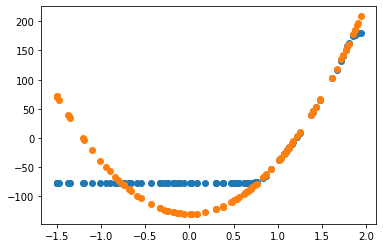

In [87]:
plt.scatter(
    x,
    nn.apply(x)
)

plt.scatter(
    x,
    y
)
plt.show()

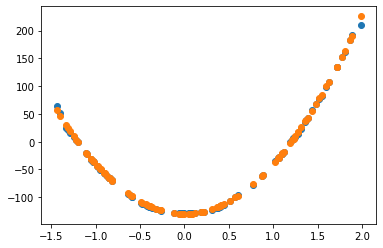

In [81]:
plt.scatter(
    x_test,
    nn.apply(x_test)
)

plt.scatter(
    x_test,
    y_test
)

In [88]:
nn.layers

[LAYER(
 W:
  array([[-2.62163212, -1.68065642, -3.25328545, -2.21222396, -2.97753231,
         -3.54540762, -2.25886217,  5.35826548, -2.17349469, -2.00653498]]) 
 b:
 array([[ 4.00286597,  1.45568843,  5.49784035,  2.78504709,  4.90644818,
          6.09204041,  2.8835131 , -4.02258498,  2.84985672,  2.36660184]])),
 LAYER(
 W:
  array([[  2.16754627,   2.77452217,   4.69641816,   4.04913352,
           3.27604763,   5.2222521 ,   2.034855  ,   1.98763826,
           2.10754407,   2.46950589],
        [  1.65128356,   1.8934012 ,   1.32523194,   0.89781607,
           1.54158621,   1.84737325,   0.49835327,   0.89574131,
           1.64218509,   0.87097477],
        [  1.75500949,   1.86145648,   6.90989111,   4.98267895,
           3.99551057,   7.11649164,   2.3299836 ,   2.89797426,
           2.44895152,   3.40645763],
        [  2.40403593,   2.70319556,   3.5303159 ,   2.26783466,
           2.35555299,   3.59825777,   1.67355532,   1.58588274,
           1.44335   ,   2.004077